In [23]:
source_name="GX 1+4"
tstart='2019-01-01T00:00:00'
tstop='2019-03-31T23:59:59'
n_scw_ima = 10
n_scw_spec_lc = 20
radius_isgri = 8
radius_j1 = 3
run_spec=True
make_image=True
make_j1_image=True
make_lc=True
run_lc_jemx1 = True
e_min = 28.
e_max = 50.
e_min_j1 = 3.
e_max_j1 = 20.

In [2]:
from importlib import reload

In [3]:
import logging
#logging.getLogger().setLevel(logging.WARNING)
logging.getLogger().setLevel(logging.INFO) #for more verbose logging

logging.getLogger('').addHandler(logging.StreamHandler()) 

In [4]:
import os,sys
lib_path=os.path.abspath('/home/ferrigno/Soft/oda_api')
if lib_path not in sys.path:
    sys.path.append(lib_path)
else:
    print("Not appending")
import oda_api

## Get the token

In [5]:
import oda_api.token
token = oda_api.token.discover_token()
oda_api.token.decode_oda_token(token)

decoding token with jwt and NOT verifying
found token in environment variable ODA_TOKEN your token payload: {
    "email": "Carlo.Ferrigno@unige.ch",
    "exp": 1638890893,
    "name": "cferrigno",
    "roles": "authenticated user, administrator, user manager, content manager, general, integral-private-qla, magic, unige-hpc-full, public-pool-hpc, antares, sdss",
    "sub": "Carlo.Ferrigno@unige.ch"
}
token expires in 291.1 h
decoding token with jwt and NOT verifying


{'sub': 'Carlo.Ferrigno@unige.ch',
 'email': 'Carlo.Ferrigno@unige.ch',
 'name': 'cferrigno',
 'roles': 'authenticated user, administrator, user manager, content manager, general, integral-private-qla, magic, unige-hpc-full, public-pool-hpc, antares, sdss',
 'exp': 1638890893}

In [11]:
from astroquery.simbad import Simbad
from astropy import units as u
from astropy.coordinates import SkyCoord


simbad = Simbad.query_object(source_name)
coord = SkyCoord(simbad['RA'], simbad['DEC'], unit=[u.hour, u.deg])
coord.fk5

#coord = SkyCoord(ra,dec, unit=[u.deg, u.deg])
ra = coord.ra.deg
dec = coord.dec.deg
print("Coordinates for %s are RA=%.4f, Dec=%.4f"%(source_name,ra,dec ) )

Coordinates for GX 1+4 are RA=263.0090, Dec=-24.7456


## We make an image

In [30]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min,
"E2_keV": e_max,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_isgri,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_ima,
"detection_threshold": "7.0",
"instrument": "isgri",
"integral_data_rights": "public",
"oda_api_version": "1.1.22",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "isgri_image",
"product_type": "Real",

}

In [31]:
import oda_api.api
host="https://www.astro.unige.ch/mmoda/dispatch-data"

disp = oda_api.api.DispatcherAPI(url=host)

if make_image:
    
    isgri_image=disp.get_product(**par_dict)


/home/ferrigno/Soft/oda_api/oda_api/api.py:891: UserWarning: 
----------------------------------------------------------------------------
the parameter: oda_api_version   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'E1_keV', 'E2_keV', 'detection_threshold', 'image_scale_min', 'image_scale_max']
this will throw an error in a future version 
and might break the current request!
 ----------------------------------------------------------------------------

  warnings.warn(msg)
- waiting for remote response (since 2021-11-25 13:55:42), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: I0IZAET3AMLJJ39B job: aed97c268654ca54

... query status prepared => done
... assigned job id: aed97c268654ca54
query COMPLETED SUCCESSFULLY (state done)
query complete: terminating


In [32]:
%matplotlib notebook

## We can look at the image and use sliders to adjust the contrast

<IPython.core.display.Javascript object>


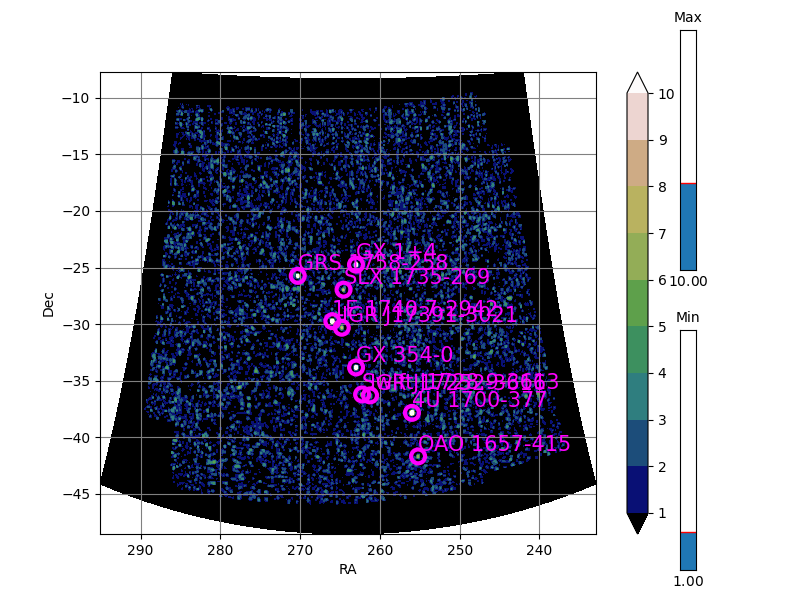

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58526.447905 from DATE-OBS.
Set MJD-END to 58557.991262 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58526.447905 from DATE-OBS.
Set MJD-END to 58557.991262 from DATE-END'.
/home/ferrigno/Soft/oda_api/oda_api/plot_tools.py:109: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gist_earth").copy()
  plt.xlim([ra.max(), ra.min()])


In [33]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(isgri_image)
_=image.show()

## We get the catalog from the image to be used in the light curves and spectra
- note that we can add an object of interest in the case it is not detected in the mosaic and to assign a FLAG=1
- Coordinates are derived from Simbad, or dirctly given as objects_of_interest=[(source_name, coord)], see above for the coord definition

In [58]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(isgri_image)
catalog_string = image.extract_catalog_string_from_image(objects_of_interest=[source_name])

Elaborating object of interest: GX 1+4 263.008977 -24.745590
RA=263.009 Dec=-24.7456
Found GX 1+4 in catalog


In [39]:
catalog_string

'{"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[3, 20, 46, 47, 54, 128, 150, 245, 262, 277], ["1E 1740.7-2942", "4U 1700-377", "GRS 1758-258", "GX 1+4", "GX 354-0", "IGR J17252-3616", "IGR J17391-3021", "OAO 1657-415", "SLX 1735-269", "Swift J1728.9-3613"], [37.77094268798828, 35.79611587524414, 23.00543785095215, 38.75000762939453, 33.56985092163086, 7.799460411071777, 8.421113014221191, 8.176356315612793, 8.559125900268555, 9.243657112121582], [265.9716796875, 255.99024963378906, 270.3056640625, 263.0048828125, 262.99346923828125, 261.2395935058594, 264.7843322753906, 255.21841430664062, 264.5645751953125, 262.23870849609375], [-29.741472244262695, -37.84401321411133, -25.738916397094727, -24.74757957458496, -33.83165740966797, -36.302249908447266, -30.321863174438477, -41.690799713134766, -26.958356857299805, -36.21576690673828], [-32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768], [2, 2, 2, 2, 2, 1, 2, 2, 2, 2], [0, 0, 0, 1, 0, 0, 0

## We make an imag for JEM-X1 and visualize it

In [24]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min_j1,
"E2_keV": e_max_j1,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_j1,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_ima,
"jemx_num": "1",
"osa_version": "OSA11.1",
"detection_threshold": "7.0",
"integral_data_rights": "public",
"instrument": "jemx",
"product": "jemx_image",
"product_type": "Real",
"off_line": "False",
}

In [25]:
reload(oda_api)
disp = oda_api.api.DispatcherAPI(url=host)

if make_j1_image:
    
    j1_image=disp.get_product(**par_dict)
        


- waiting for remote response (since 2021-11-25 13:38:10), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: ZV3OYMCHXWQT5AUN job: d54647bb70eef4b9

... query status prepared => submitted
... assigned job id: d54647bb70eef4b9
 | the job is working remotely, please wait status=submitted job_id=d54647bb in 0 messages since 16 seconds (16/16); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-11-25 13:38:28), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: ZV3OYMCHXWQT5AUN job: d54647bb70eef4b9

... query status submitted => progress
 / the job is working remotely, please wait status=progress job_id=d54647bb in 2 messages since 24 seconds (12/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
... mosaic_jemx_osa : treating dependencies : inapplicable
- waiting for remote response (since 2021-11-25 13:38:35), please wait for https://www.astro.unige.ch/mmoda/dispatch-da

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


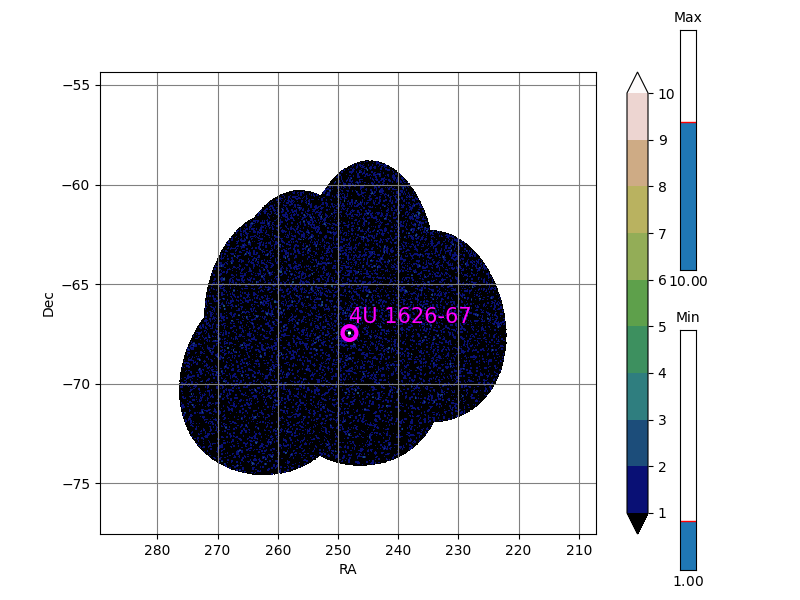

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''.
/home/ferrigno/Soft/oda_api/oda_api/plot_tools.py:103: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gist_earth").copy()
  self.cs.cmap.set_under('k')


In [12]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(j1_image)
_=image.show()

## We can write in fits file

In [13]:
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(j1_image)
image.write_fits('J1_')

## We can make a light curve and simply visualize it

In [55]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min,
"E2_keV": e_max,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_isgri,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"instrument": "isgri",
"integral_data_rights": "public",
"osa_version": "OSA11.1",
"product": "isgri_lc",
"product_type": "Real",
"time_bin": "1000",
"token": token,
"selected_catalog": catalog_string
}


In [56]:
reload(oda_api)
disp = oda_api.api.DispatcherAPI(url=host)
if make_lc:

    combined_data=disp.get_product(**par_dict)
        
        

- waiting for remote response (since 2021-11-25 15:56:08), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: 7O4Z0W68LJLOMF6H job: 939e2f6a95be408e

... query status prepared => done
... assigned job id: 939e2f6a95be408e
query COMPLETED SUCCESSFULLY (state done)
query complete: terminating


<IPython.core.display.Javascript object>


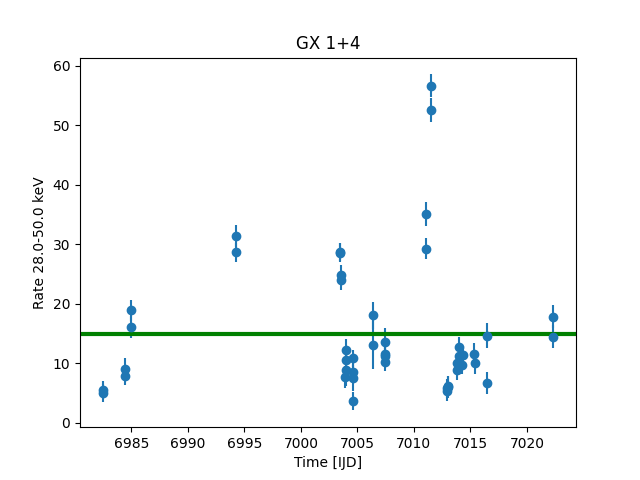

In [57]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaLightCurve(combined_data)
_=image.show(source_name)

## We can search for thermonuclear bursts in the JEM-X light curve

In [59]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min_j1,
"E2_keV": e_max_j1,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_j1,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"instrument": "jemx",
"integral_data_rights": "public",
"jemx_num": "1",
"oda_api_version": "1.1.22",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "jemx_lc",
"product_type": "Real",
"selected_catalog": catalog_string,
"src_name": "1E 1740.7-2942",
"time_bin": "4",
"token": token}

In [60]:
if run_lc_jemx1 :
    
    disp = oda_api.api.DispatcherAPI(url=host)
        
    combined_data=disp.get_product(**par_dict)


/home/ferrigno/Soft/oda_api/oda_api/api.py:891: UserWarning: 
----------------------------------------------------------------------------
the parameter: oda_api_version   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'jemx_num', 'E1_keV', 'E2_keV', 'time_bin']
this will throw an error in a future version 
and might break the current request!
 ----------------------------------------------------------------------------

  warnings.warn(msg)
- waiting for remote response (since 2021-11-25 16:01:36), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: FA48E2LCWRXX0YJ5 job: 6925787c7551a55e

... query status prepared => done
... assigned job id: 6925787c7551a55e
query COMPLETED SUCCESSFULLY (state done)
query complete: terminating


## Advanced display of light curves
- with the keyword ng_sig_limit you can select the limit for variability in standard deviations
- with the keyword find_excesses you can find points above this limit, which can be useful to find thermonuclear bursts 

<IPython.core.display.Javascript object>


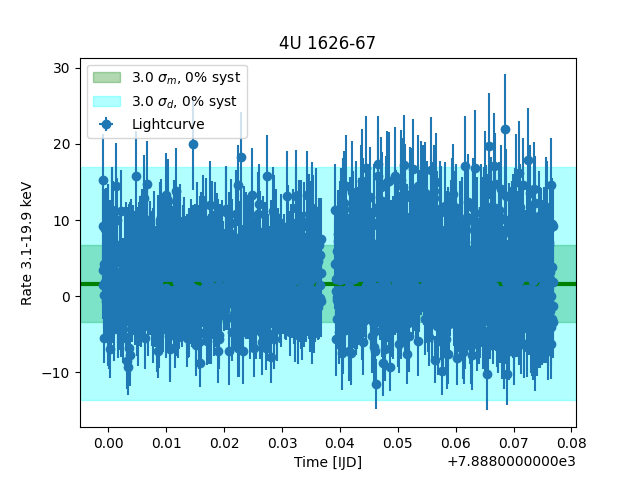

In [20]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
lc = oda_api.plot_tools.OdaLightCurve(combined_data)
_=lc.show(source_name, ng_sig_limit=3.0, find_excesses=True)


## This writes the light curve as a fits file

In [22]:
lc.write_fits(source_name)

('./JMX1_lc_4U_1626-67.fits', 59431.99898149915, 59432.07689816582, -1)

## spectral products jem-x1

In [49]:
par_dict = {
    "DEC": "%f" % dec,
"E1_keV": e_min_j1,
"E2_keV": e_max_j1,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_j1,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"api": "True",
"instrument": "jemx",
"integral_data_rights": "public",
"jemx_num": "1",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "jemx_spectrum",
"product_type": "Real",
"selected_catalog": catalog_string,
"token": token,
}


In [50]:
j1_spec = disp.get_product(**par_dict)

/home/ferrigno/Soft/oda_api/oda_api/api.py:891: UserWarning: 
----------------------------------------------------------------------------
the parameter: api   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'jemx_num', 'E1_keV', 'E2_keV']
this will throw an error in a future version 
and might break the current request!
 ----------------------------------------------------------------------------

  warnings.warn(msg)
- waiting for remote response (since 2021-11-25 15:51:39), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: FA48E2LCWRXX0YJ5 job: fe227037cdee5677

... query status prepared => submitted
... assigned job id: fe227037cdee5677
 / the job is working remotely, please wait status=submitted job_id=fe227037 in 0 messages since 16 seconds (6.8/17); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote 

KeyboardInterrupt: 

In [53]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min,
"E2_keV": e_max,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_isgri,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"instrument": "isgri",
"integral_data_rights": "public",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "isgri_spectrum",
"token": token,
}


In [54]:
isgri_spec = disp.get_product(**par_dict)

- waiting for remote response (since 2021-11-25 15:54:53), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: FA48E2LCWRXX0YJ5 job: ce27a135f2042ee2

... query status prepared => submitted
... assigned job id: ce27a135f2042ee2
 - the job is working remotely, please wait status=submitted job_id=ce27a135 in 0 messages since 19 seconds (6.5/19); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-11-25 15:55:14), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: FA48E2LCWRXX0YJ5 job: ce27a135f2042ee2
 \ the job is working remotely, please wait status=submitted job_id=ce27a135 in 0 messages since 25 seconds (6.5/19); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
- waiting for remote response (since 2021-11-25 15:55:19), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: FA48E2LCWRXX0YJ5 job: ce27a135f2042ee2
 | the job is working remot

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


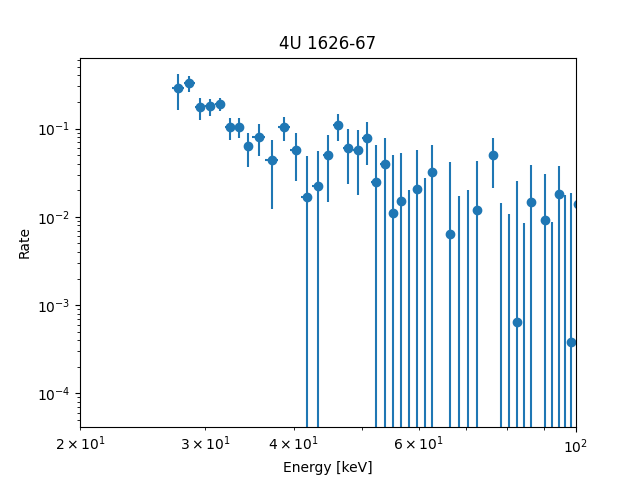

In [28]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
spec = oda_api.plot_tools.OdaSpectrum(isgri_spec)
#spec.show_spectral_products()
_ = spec.show(source_name, xlim=[20,100])

## This saves spectrum arf and response in a way to be used with xspec 
- systematic fraction adds a systematic fraction to the spectrum
- grouping performs a grouping on the spectrum the argument is [minimum_energy, maximum_energy, bins]
    - bins is the number of bin spaced logarithmically if negative, linearly if positive 

In [30]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
spec = oda_api.plot_tools.OdaSpectrum(isgri_spec)
spec.write_fits(source_name, systematic_fraction=0.01, grouping=[30,150,-20])

Saving spectrum ./IBIS_spectrum_4U_1626-67.fits with rmf ./IBIS_rmf_4U_1626-67.fits and arf ./IBIS_arf_4U_1626-67.fits
Geometric grouping with step 1.084


('./IBIS_spectrum_4U_1626-67.fits',
 59473.69966879156,
 59474.80541022275,
 52554.66590833641)